In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [2]:
#Loading Visual training data
x_train_wr = np.load('x_train_wr.npy')
x_train_wr = x_train_wr.reshape(-1,28,28)

#Loading Audio training data
x_train_sp = np.load('x_train_sp.npy')

#loading Visual testing data
x_test_wr = np.load('x_test_wr.npy')
x_test_wr = x_test_wr.reshape(-1,28,28)

#loading Audio Testing data
x_test_sp = np.load('x_test_sp.npy')

#Labels for the training data
y_train = pd.read_csv('y_train.csv')['label'].values


In [3]:
# Normalize image data
x_train_wr = x_train_wr.astype(np.float32) / 255.0
x_test_wr = x_test_wr.astype(np.float32) / 255.0

In [4]:
# Standardize audio data
scaler = StandardScaler()
x_train_sp = scaler.fit_transform(x_train_sp)
x_test_sp = scaler.transform(x_test_sp)

In [5]:
class DigitDataset(Dataset):
    """
    Dataset class for combining images and audio samples with optional labels.

    """
    def __init__(self, images, audios, labels=None, transform=None):
        self.images = images 
        self.audios = audios
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        audio = self.audios[idx]
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            label = self.labels[idx]
            return image, audio, label
        return image, audio

In [6]:
def data_loader(train_data: DigitDataset, batch_size: int, validation_split: float):
    """
    Create DataLoader objects for training and validation datasets with a specified validation split.
    """
    dataset_size = len(train_data)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split*dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    #Create DataLoader objects for training and validation datasets using the samplers
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size,sampler=train_sampler)
    val_loader = DataLoader(dataset=train_data, batch_size=batch_size, sampler=val_sampler)

    return train_loader, val_loader

In [7]:
transform = transforms.Compose([transforms.ToTensor(),])
train_dataset = DigitDataset(x_train_wr, x_train_sp, y_train, transform=transform)
test_dataset = DigitDataset(x_test_wr, x_test_sp, transform=transform)

In [8]:
# Batch size and validation split
batch_size = 8
validation_split = 0.20

train_loader, val_loader = data_loader(train_dataset, batch_size, validation_split)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
for image, audio, label in train_loader:
    # Print the shape of one batch of images and labels
    print(f"Shape of one batch of images in training dataset is,  {image.shape = }")
    print(f"Shape of one batch of  in training dataset audio is,  {audio.shape = }")
    print(f"Shape of one batch of  in training dataset  label is, {label.shape = }")
    break

Shape of one batch of images in training dataset is,  image.shape = torch.Size([8, 1, 28, 28])
Shape of one batch of  in training dataset audio is,  audio.shape = torch.Size([8, 507])
Shape of one batch of  in training dataset  label is, label.shape = torch.Size([8])


In [10]:
for image, audio, label in val_loader:
    # Print the shape of one batch of images and labels
    print(f"Shape of one batch of images in validation dataset is,  {image.shape = }")
    print(f"Shape of one batch of  in validation dataset audio is,  {audio.shape = }")
    print(f"Shape of one batch of  in validation dataset  label is, {label.shape = }")
    break

Shape of one batch of images in validation dataset is,  image.shape = torch.Size([8, 1, 28, 28])
Shape of one batch of  in validation dataset audio is,  audio.shape = torch.Size([8, 507])
Shape of one batch of  in validation dataset  label is, label.shape = torch.Size([8])


In [11]:
for image, audio in test_loader:
    # Print the shape of one batch of images and labels
    print(f"Shape of one batch of in test dataset images is,  {image.shape = }")
    print(f"Shape of one batch of in test dataset audio is,  {audio.shape = }")
    break

Shape of one batch of in test dataset images is,  image.shape = torch.Size([8, 1, 28, 28])
Shape of one batch of in test dataset audio is,  audio.shape = torch.Size([8, 507])


In [12]:
class ImageEncoder(nn.Module):
    """
    Convolutional neural network for encoding image data.
    """
    def __init__(self):
        super(ImageEncoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.50)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.50)

        # self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.50)
        self.fc2 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        
           

    def forward(self, x):
        x = self.dropout1(self.pool1(self.relu1(self.conv1(x))))
        x = self.dropout2(self.pool2(self.relu2(self.conv2(x))))
        x = x.view(-1, 32*7*7)
        x = self.dropout3(self.relu3(self.fc1(x)))
        x = self.relu4(self.fc2(x))

        return x

In [13]:
class AudioEncoder(nn.Module):
    """
    Convolutional neural network for encoding audio data.
    """
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.50)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.50)

    
        self.fc1 = nn.Linear(64 * 126, 128)  
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.50)
        self.fc2 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.dropout1(self.pool1(self.relu1(self.conv1(x))))
        x = self.dropout2(self.pool2(self.relu2(self.conv2(x))))
        x = x.view(-1, 64 * 126) 
        x = self.dropout3(self.relu3(self.fc1(x)))
        x = self.relu4(self.fc2(x))
        return x


In [14]:
class FusionModel(nn.Module):
    """
    Neural network model for fusing features from image and audio encoders.
    """
    def __init__(self):
        super(FusionModel, self).__init__()
        self.image_encoder = ImageEncoder()
        self.audio_encoder = AudioEncoder()

        self.fc = nn.Linear(128, 10) #final dense layer
        
        

    def forward(self, image, audio):
        img_features = self.image_encoder(image)
        audio_features = self.audio_encoder(audio)
        combined_features = torch.cat((img_features, audio_features), dim=1) #combining features from image and audio encoders
        output = self.fc(combined_features)
        return output

In [15]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    """
    model.train()  #Set the model to training mode
    train_loss = 0
    correct = 0
    total = 0

    #Iterate over the training data
    for images, audios, labels in train_loader:
        images, audios, labels = images.to(device).float(), audios.to(device).float(), labels.to(device).float()

        #Forward pass
        outputs = model(images, audios)
        outputs = outputs.float()
        labels = labels.long()
        loss = criterion(outputs, labels) #Calculate the loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward() #Backpropagation
        optimizer.step()

        train_loss += loss.item() #Updatetraining loss

        #calculate accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return avg_train_loss, train_accuracy

In [16]:
def evaluate_model(model, val_loader, criterion, device):
    """
    Evaluate the model on the validation dataset
    """
    model.eval()  #Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        # Iterate over the validation data
        for images, audios, labels in val_loader:
            images, audios, labels = images.to(device).float(), audios.to(device).float(), labels.to(device).float() #move inputs and labels to either CPU or GPU

            outputs = model(images, audios) #Forward pass
            outputs = outputs.float()
            labels = labels.long()
            loss = criterion(outputs, labels) #Calculate the loss
            val_loss += loss.item()

            #calculate accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    #Calculate average validation loss and validation accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return avg_val_loss, val_accuracy

In [17]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    """
    Train the model for a specified number of epochs and evaluate it on the validation dataset.
    """
    #Determine the device (CPU or GPU) for computations
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    model = model.to(device).float() #move the model to appropriate device

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []

    for epoch in range(num_epochs):
        avg_train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device) #model training
        avg_val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device) #model evaluation

        training_loss.append(avg_train_loss)
        training_accuracy.append(train_accuracy)
        validation_loss.append(avg_val_loss)
        validation_accuracy.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Return the trained model and the lists of training and validation metrics
    return model, (training_loss, validation_loss, training_accuracy, validation_accuracy)

In [18]:
model = FusionModel()
trained_model, (training_loss, validation_loss, training_accuracy, validation_accuracy) = train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.0001)

Training on device: cuda
Epoch 1/50, Training Loss: 0.7007, Training Accuracy: 76.74%, Validation Loss: 0.1913, Validation Accuracy: 93.96%
Epoch 2/50, Training Loss: 0.2553, Training Accuracy: 92.22%, Validation Loss: 0.1084, Validation Accuracy: 96.69%
Epoch 3/50, Training Loss: 0.1887, Training Accuracy: 94.14%, Validation Loss: 0.0837, Validation Accuracy: 97.46%
Epoch 4/50, Training Loss: 0.1579, Training Accuracy: 95.17%, Validation Loss: 0.0718, Validation Accuracy: 97.85%
Epoch 5/50, Training Loss: 0.1351, Training Accuracy: 95.75%, Validation Loss: 0.0627, Validation Accuracy: 98.18%
Epoch 6/50, Training Loss: 0.1202, Training Accuracy: 96.32%, Validation Loss: 0.0595, Validation Accuracy: 98.26%
Epoch 7/50, Training Loss: 0.1093, Training Accuracy: 96.60%, Validation Loss: 0.0511, Validation Accuracy: 98.46%
Epoch 8/50, Training Loss: 0.0974, Training Accuracy: 96.94%, Validation Loss: 0.0471, Validation Accuracy: 98.61%
Epoch 9/50, Training Loss: 0.0896, Training Accuracy: 9

In [19]:
torch.save(trained_model.state_dict(), 'trained_model.pth')  #save the trained model

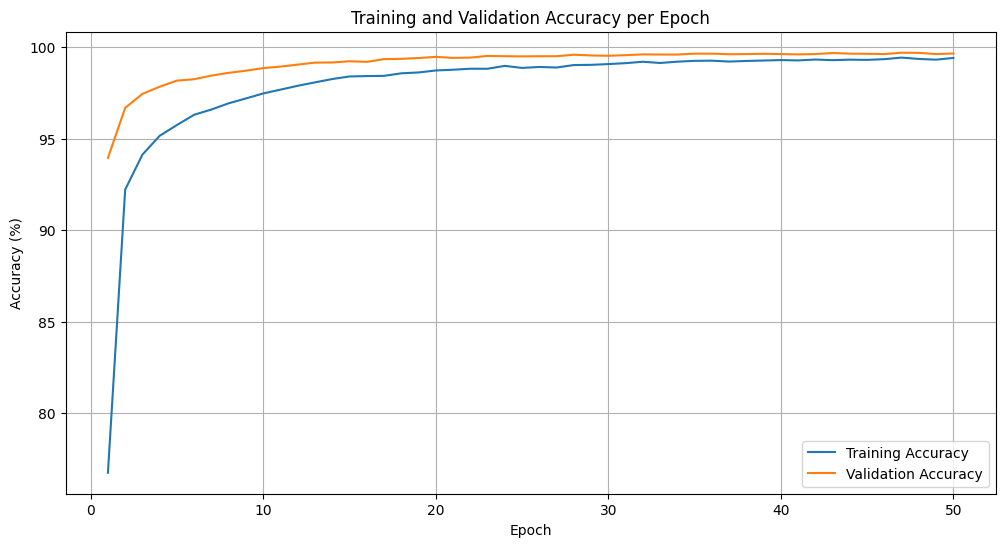

In [20]:


epochs = range(1, len(training_accuracy) + 1)

# Creating the plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

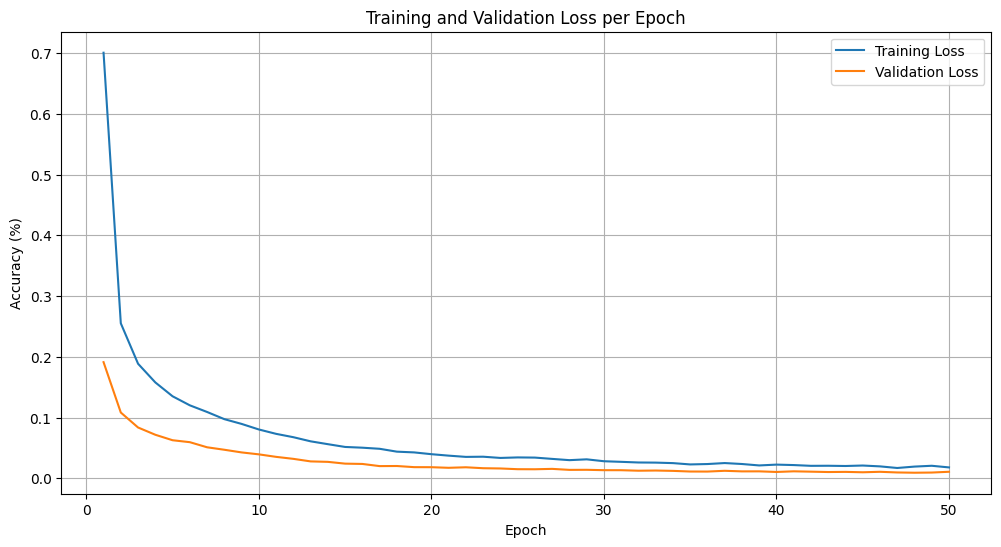

In [21]:
# Creating the plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
def evaluate_and_predict(model, device, test_loader):
    """
    Evaluate a PyTorch model on a test dataset and make predictions.
    """
    model.eval()
    all_preds = []
    with torch.no_grad():
        for images, audios in test_loader:
            images, audios = images.to(device).float(), audios.to(device).float()
            outputs = model(images, audios)
            outputs = outputs.float()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
    return np.array(all_preds)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions = evaluate_and_predict(trained_model, device, test_loader)
pd.DataFrame(predictions, columns=['Digit_Prediction']).to_csv('Jasdeep_Bajaj_Preds.csv', index_label='row_id')

In [24]:
image_encodings = []
audio_encodings = []
combined_encodings = []

labels = []

for img, aud, lab in train_dataset:
    encod_img = trained_model.image_encoder(img.to(device).float())
    encod_np_img = encod_img.cpu().detach().numpy()
    image_encodings.append(encod_np_img)
    
    aud = torch.from_numpy(aud).float()
    aud = aud.reshape(-1,507)
    encod_aud = trained_model.audio_encoder(aud.to(device))
    encod_np_aud = encod_aud.cpu().detach().numpy()
    audio_encodings.append(encod_np_aud)

    encod = trained_model(img.to(device).float(), aud.to(device))
    encod_np = encod.cpu().detach().numpy()
    combined_encodings.append(encod_np)
    
    labels.append(lab)

labels = np.array(labels)

image_encodings_np = np.array(image_encodings)
image_encodings_np = image_encodings_np.reshape(-1, 64)

audio_encodings_np = np.array(audio_encodings)
audio_encodings_np = audio_encodings_np.reshape(-1, 64)

combined_encodings_np = np.array(combined_encodings)
combined_encodings_np = combined_encodings_np.reshape(-1, 10)
    

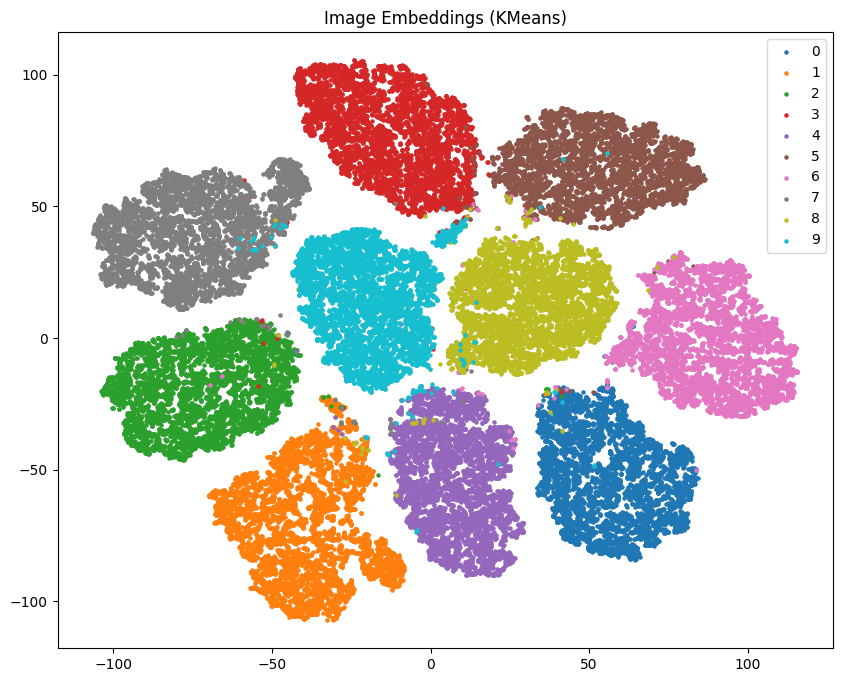

In [25]:
tsne = TSNE(n_components=2, random_state=42)
img_tsne = tsne.fit_transform(image_encodings_np)
kmeans_img = KMeans(n_clusters=10, random_state=42).fit_predict(img_tsne)

plt.figure(figsize=(10, 8))

for i in range(10):
    plt.scatter(img_tsne[labels == i, 0], img_tsne[labels == i, 1], label = str(i), s=5)
plt.title("Image Embeddings (KMeans)")
plt.legend()
plt.show()

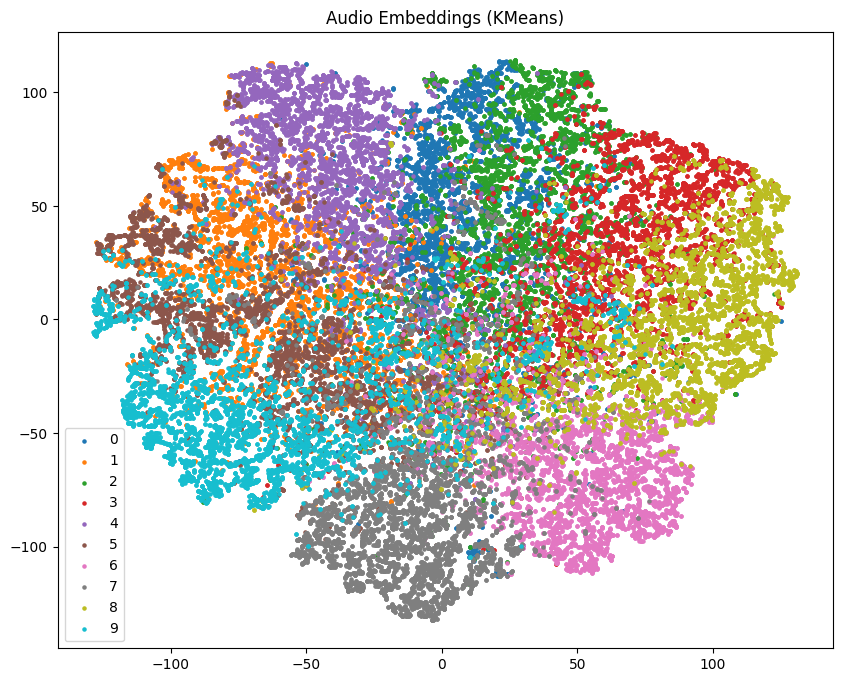

In [26]:
tsne = TSNE(n_components=2, random_state=42)
audio_tsne = tsne.fit_transform(audio_encodings_np)
kmeans_aud = KMeans(n_clusters=10, random_state=42).fit_predict(audio_tsne)

plt.figure(figsize=(10, 8))

for i in range(10):
    plt.scatter(audio_tsne[labels == i, 0], audio_tsne[labels == i, 1], label = str(i), s=5)
plt.title("Audio Embeddings (KMeans)")
plt.legend()
plt.show()


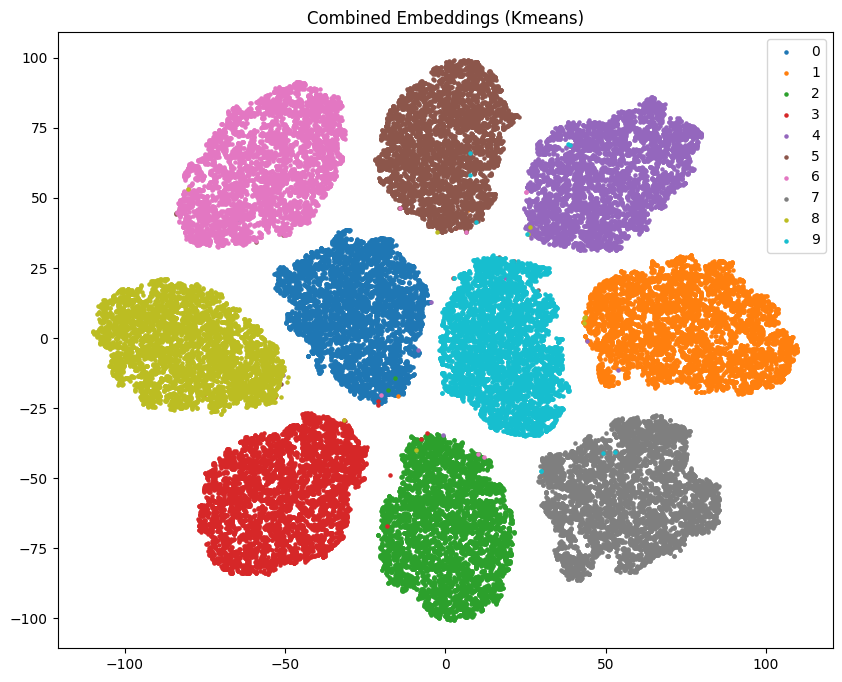

In [27]:
tsne = TSNE(n_components=2, random_state=42)
combined_tsne = tsne.fit_transform(combined_encodings_np)
kmeans_combined = KMeans(n_clusters=10, random_state=42).fit_predict(combined_tsne)

plt.figure(figsize=(10, 8))

for i in range(10):
    plt.scatter(combined_tsne[labels == i, 0], combined_tsne[labels == i, 1], label = str(i), s=5)
plt.title("Combined Embeddings (Kmeans)")
plt.legend()
plt.show()